In [1]:
from Libreria.cargar_configbd import cargar_configbd
from Libreria.matriz_de_confusion import matriz_de_confusion

import os
import pandas as pd  
import numpy as np  
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

In [2]:
# Conectar a la base de datos PostgreSQL
conn = cargar_configbd.conectar_base_datos('conf_bd.txt')
cur = conn.cursor()

In [3]:
cur.execute(f"SELECT * FROM datos_uda_reglas;") # Son los viajes etiqetados por toda lo metodologia
# Obtener los resultados de la consulta
rows = cur.fetchall()

df_modos = pd.DataFrame(rows.copy(), columns=[desc[0] for desc in cur.description])

num_elementos_por_grupo = df_modos.groupby('etiqueta').size()
print(num_elementos_por_grupo)

etiqueta
AUTOMOVIL    110
BICICLETA    110
BUS          110
CAMINATA     110
dtype: int64


In [4]:
data = df_modos.copy()

In [5]:
def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
    return X_normalized_df

# Extraer las características (X) y las etiquetas (y) del DataFrame
X = data.iloc[:, 3:-1]  # Todas las filas, todas las columnas excepto la última
y = data.iloc[:, -1]   # Todas las filas, solo la última columna

# Codificar las etiquetas de la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y, random_state=42)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y_encoded, test_size = 0.30, stratify=y, random_state=42)

In [6]:
selected_features = joblib.load('selected_features.joblib')

# Imprime las características seleccionadas en orden de importancia
print(selected_features)

Index(['max_speed', 'mean_time_stop', 'max_time_stop', 'p25_speed',
       'mean_speed', 'p75_time_stop', 'p75_speed', 'var_time_stop',
       'median_time_stop', 'median_speed', 'p25_time_stop', 'stops',
       'p75_aceleration', 'var_bearing', 'min_speed', 'min_time_stop',
       'min_bearing', 'max_aceleration', 'var_speed', 'p25_bearing',
       'max_bearing', 'median_aceleration', 'mean_aceleration', 'p75_bearing',
       'min_aceleration', 'mean_bearing', 'var_aceleration', 'p25_aceleration',
       'median_bearing'],
      dtype='object')


In [7]:
import pickle

def cargar_predicciones_modelos():
    file_path = 'predicciones_modelos.pkl'
    initial_data = {}
    
    if not os.path.exists(file_path):
        # Crear el archivo Pickle con datos iniciales si no existe
        with open(file_path, 'wb') as file:
            pickle.dump(initial_data, file)
        #print(f"Archivo creado: {file_path}")

    # Cargar los datos del archivo Pickle
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        #print(f"Datos cargados desde {file_path}")

    return data

def guardar_predicciones_modelos(models_predictions):
    # Nombre del archivo JSON
    file_path = 'predicciones_modelos.pkl'

    # Guardar el diccionario en un archivo pickle
    with open(file_path, 'wb') as file:
        pickle.dump(models_predictions, file)

In [8]:
# Guardar etiquetas reales
predicciones_modelos = cargar_predicciones_modelos()
predicciones_modelos['y_test'] = y_test
guardar_predicciones_modelos(predicciones_modelos)

In [9]:
### DECISION TREE

In [9]:
# Definir el param_grid para DecisionTreeClassifier
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

dt_nfeatures = 22

# Crear un objeto GridSearchCV para DecisionTreeClassifier
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, refit=True, verbose=0)

# Realizar la búsqueda de cuadrícula
grid_tree.fit(X_train[selected_features[:dt_nfeatures]], y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5, 10]})

Precisión del modelo en el conjunto de entrenamiento: 0.9772727272727273
Precisión del modelo en el conjunto de prueba: 0.9318181818181819


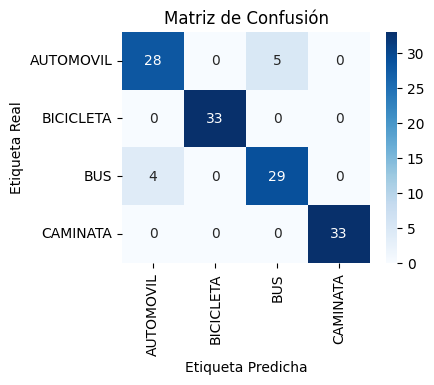


Classification Report for the Best Model:
              precision    recall  f1-score   support

   AUTOMOVIL       0.88      0.85      0.86        33
   BICICLETA       1.00      1.00      1.00        33
         BUS       0.85      0.88      0.87        33
    CAMINATA       1.00      1.00      1.00        33

    accuracy                           0.93       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



In [10]:

best_tree = grid_tree.best_estimator_

y_test_pred = best_tree.predict(X_test[selected_features[:dt_nfeatures]])
y_train_pred = best_tree.predict(X_train[selected_features[:dt_nfeatures]])

# Guardar predicciones
predicciones_modelos = cargar_predicciones_modelos()
predicciones_modelos['DT'] = y_test_pred
guardar_predicciones_modelos(predicciones_modelos)

# Calcular el accuracy para conjuntos de entrenamiento y prueba
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Precisión del modelo en el conjunto de entrenamiento:", train_accuracy)
print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Calcular y mostrar la matriz de confusión
matriz_de_confusion.heatmap(y_test, y_test_pred)

# Calcular y mostrar el reporte de clasificación
class_report_best = classification_report(y_test, y_test_pred)
print("\nClassification Report for the Best Model:")
print(class_report_best)

In [11]:
# Obtener los hiperparámetros del mejor estimador
best_params = grid_tree.best_params_

print("Los hiperparámetros del mejor estimador son:")
for param_name, param_value in best_params.items():
    print(f"{param_name}: {param_value}")

Los hiperparámetros del mejor estimador son:
criterion: entropy
max_depth: None
min_samples_leaf: 4
min_samples_split: 2


In [12]:
tree_rules = export_text(best_tree, feature_names=selected_features[:dt_nfeatures])
print(tree_rules)

|--- max_speed <= 11.10
|   |--- p25_speed <= 1.31
|   |   |--- class: CAMINATA
|   |--- p25_speed >  1.31
|   |   |--- class: BICICLETA
|--- max_speed >  11.10
|   |--- mean_time_stop <= 24.12
|   |   |--- p75_time_stop <= 11.12
|   |   |   |--- median_aceleration <= 0.01
|   |   |   |   |--- class: AUTOMOVIL
|   |   |   |--- median_aceleration >  0.01
|   |   |   |   |--- p75_aceleration <= 1.13
|   |   |   |   |   |--- max_speed <= 26.05
|   |   |   |   |   |   |--- p75_aceleration <= 0.44
|   |   |   |   |   |   |   |--- class: AUTOMOVIL
|   |   |   |   |   |   |--- p75_aceleration >  0.44
|   |   |   |   |   |   |   |--- class: BUS
|   |   |   |   |   |--- max_speed >  26.05
|   |   |   |   |   |   |--- class: AUTOMOVIL
|   |   |   |   |--- p75_aceleration >  1.13
|   |   |   |   |   |--- class: AUTOMOVIL
|   |   |--- p75_time_stop >  11.12
|   |   |   |--- var_speed <= 29.69
|   |   |   |   |--- max_speed <= 14.28
|   |   |   |   |   |--- class: BUS
|   |   |   |   |--- max_speed

In [27]:
from sklearn.tree import export_graphviz
import graphviz
unique_labels = np.unique(y_test)
sorted_labels = sorted(unique_labels)


# Exportar el árbol a formato DOT (Graphviz)
dot_data = export_graphviz(
    best_tree,
    out_file=None,
    feature_names=selected_features[:dt_nfeatures],
    class_names=unique_labels,  # Reemplazar con tus nombres de clases
    filled=True,
    rounded=True,
    special_characters=True
)

# Crear el gráfico con graphviz
graph = graphviz.Source(dot_data)

# Guardar el gráfico como PNG
graph.format = 'png'
graph.render("decision_tree")  # Esto guarda el archivo como decision_tree.png
graph.view()

# Si quieres evitar que se guarden otros formatos adicionales, puedes especificar directamente la ruta
graph.render("decision_tree", format='png')  # Esto guarda específicamente como PNG

'decision_tree.png'

In [ ]:
### SVM

In [14]:
param_grid_svm = {
    'C': [0.01, 0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid']
    #'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_nfeatures = 2

grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=0)  # verbose se usa solo para efectos de demostración
grid_svm.fit(X_train[selected_features[:svm_nfeatures]], y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']})

Precisión del modelo en el conjunto de entrenamiento: 0.8928571428571429
Precisión del modelo en el conjunto de prueba: 0.8484848484848485


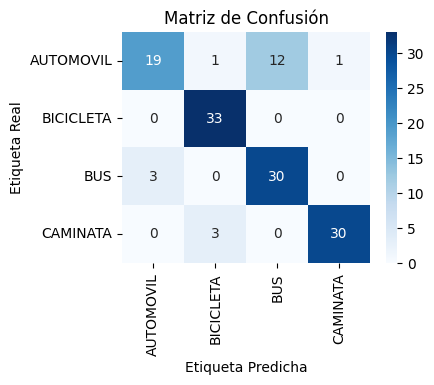


Classification Report for the Best Model:
              precision    recall  f1-score   support

    CAMINATA       0.86      0.58      0.69        33
   BICICLETA       0.89      1.00      0.94        33
         BUS       0.71      0.91      0.80        33
   AUTOMOVIL       0.97      0.91      0.94        33

    accuracy                           0.85       132
   macro avg       0.86      0.85      0.84       132
weighted avg       0.86      0.85      0.84       132



In [15]:
best_svm = grid_svm.best_estimator_

y_test_pred = best_svm.predict(X_test[selected_features[:svm_nfeatures]])
y_train_pred = best_svm.predict(X_train[selected_features[:svm_nfeatures]])

# Guardar predicciones
predicciones_modelos = cargar_predicciones_modelos()
predicciones_modelos['SVM'] = y_test_pred
guardar_predicciones_modelos(predicciones_modelos)

# Calcular el accuracy para conjuntos de entrenamiento y prueba
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Precisión del modelo en el conjunto de entrenamiento:", train_accuracy)
print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Calcular y mostrar la matriz de confusión
matriz_de_confusion.heatmap(y_test, y_test_pred)

# Calcular y mostrar el reporte de clasificación
class_report_best = classification_report(y_test, y_test_pred, target_names=data['etiqueta'].unique())
print("\nClassification Report for the Best Model:")
print(class_report_best)


In [16]:
# Obtener los hiperparámetros del mejor estimador
best_params = grid_svm.best_params_

print("Los hiperparámetros del mejor estimador son:")
for param_name, param_value in best_params.items():
    print(f"{param_name}: {param_value}")


Los hiperparámetros del mejor estimador son:
C: 100
gamma: 0.001
kernel: rbf


In [ ]:
### XGBOOST

In [18]:
# Definir los parámetros para la búsqueda de cuadrícula
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_nfeatures = 14

# Inicializar el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier()

# Configurar la búsqueda de cuadrícula
grid_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0)

# Realizar la búsqueda de cuadrícula
grid_xgb.fit(X_train_e[selected_features[:xgb_nfeatures]], y_train_e)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

Precisión del modelo en el conjunto de entrenamiento: 1.0
Precisión del modelo en el conjunto de prueba: 0.946969696969697


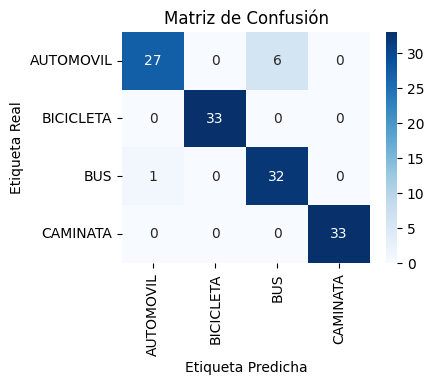


Classification Report for the Best Model:
              precision    recall  f1-score   support

    CAMINATA       0.96      0.82      0.89        33
   BICICLETA       1.00      1.00      1.00        33
         BUS       0.84      0.97      0.90        33
   AUTOMOVIL       1.00      1.00      1.00        33

    accuracy                           0.95       132
   macro avg       0.95      0.95      0.95       132
weighted avg       0.95      0.95      0.95       132



In [19]:
best_xgb = grid_xgb.best_estimator_

y_test_pred = best_xgb.predict(X_test[selected_features[:xgb_nfeatures]])
y_train_pred = best_xgb.predict(X_train[selected_features[:xgb_nfeatures]])

# Guardar predicciones
predicciones_modelos = cargar_predicciones_modelos()
predicciones_modelos['XGB'] = label_encoder.inverse_transform(y_test_pred)
guardar_predicciones_modelos(predicciones_modelos)

# Calcular el accuracy para conjuntos de entrenamiento y prueba
train_accuracy = balanced_accuracy_score(y_train_e, y_train_pred)
test_accuracy = balanced_accuracy_score(y_test_e, y_test_pred)
print("Precisión del modelo en el conjunto de entrenamiento:", train_accuracy)
print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

 
# Calcular y mostrar la matriz de confusión
matriz_de_confusion.heatmap(label_encoder.inverse_transform(y_test_e), label_encoder.inverse_transform(y_test_pred))

# Calcular y mostrar el reporte de clasificación
class_report_best = classification_report(y_test_e, y_test_pred, target_names=data['etiqueta'].unique())
print("\nClassification Report for the Best Model:")
print(class_report_best)

In [20]:
# Obtener los hiperparámetros del mejor estimador
best_params = grid_xgb.best_params_

print("Los hiperparámetros del mejor estimador son:")
for param_name, param_value in best_params.items():
    print(f"{param_name}: {param_value}")

Los hiperparámetros del mejor estimador son:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 7
n_estimators: 300
subsample: 0.8


In [ ]:
### RANDOMFOREST

In [21]:
# Definir los parámetros de la grilla
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas para estar en un nodo hoja
}

rf_nfeatures = 8 # 11

# Inicializar el clasificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Configurar la búsqueda de cuadrícula
grid_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Realizar la búsqueda de cuadrícula
grid_rf.fit(X_train[selected_features[:rf_nfeatures]], y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Precisión del modelo en el conjunto de entrenamiento: 0.9707792207792207
Precisión del modelo en el conjunto de prueba: 0.9393939393939394


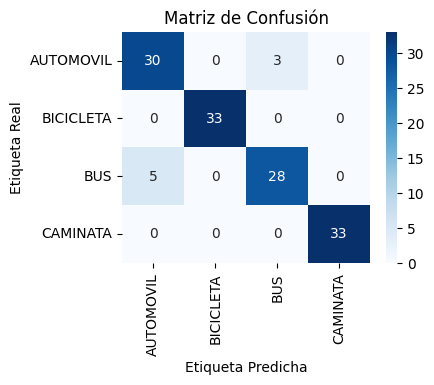


Classification Report for the Best Model:
              precision    recall  f1-score   support

    CAMINATA       0.86      0.91      0.88        33
   BICICLETA       1.00      1.00      1.00        33
         BUS       0.90      0.85      0.88        33
   AUTOMOVIL       1.00      1.00      1.00        33

    accuracy                           0.94       132
   macro avg       0.94      0.94      0.94       132
weighted avg       0.94      0.94      0.94       132



In [22]:
best_rf = grid_rf.best_estimator_

y_test_pred = best_rf.predict(X_test[selected_features[:rf_nfeatures]])
y_train_pred = best_rf.predict(X_train[selected_features[:rf_nfeatures]])

# Guardar predicciones
predicciones_modelos = cargar_predicciones_modelos()
predicciones_modelos['RF'] = y_test_pred
guardar_predicciones_modelos(predicciones_modelos)

# Calcular el accuracy para conjuntos de entrenamiento y prueba
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Precisión del modelo en el conjunto de entrenamiento:", train_accuracy)
print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Calcular y mostrar la matriz de confusión
matriz_de_confusion.heatmap(y_test, y_test_pred)

# Calcular y mostrar el reporte de clasificación
class_report_best = classification_report(y_test, y_test_pred, target_names=data['etiqueta'].unique())
print("\nClassification Report for the Best Model:")
print(class_report_best)

In [23]:
# Obtener los hiperparámetros del mejor estimador
best_params = grid_rf.best_params_

print("Los hiperparámetros del mejor estimador son:")
for param_name, param_value in best_params.items():
    print(f"{param_name}: {param_value}")

Los hiperparámetros del mejor estimador son:
max_depth: None
min_samples_leaf: 1
min_samples_split: 10
n_estimators: 100
